# Simulación de despacho de buses y predicción de demanda
Este cuaderno muestra un proceso completo para la predicción de la demanda de pasajeros en diferentes rutas y la simulación del despacho de buses, utilizando un modelo Prophet y heurísticas para el manejo de la flota.

Incluye:
- Carga y preprocesamiento de datos
- Entrenamiento del modelo Prophet
- Generación de pronósticos



In [1]:
%%capture
!pip install pandas
!pip install networkx
!pip install matplotlib
!pip install numpy
!pip install prophet
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.api.types import CategoricalDtype
from prophet.make_holidays import make_holidays_df
import joblib
import os
from datetime import datetime, timedelta
import random
import math
import pprint
import sys
sys.path.append('..')
from utils.functions import custom_save_fig, custom_save_dict

Importing plotly failed. Interactive plots will not work.


## 1. Cargar y preparar los datos

En esta sección, cargamos los datos de un archivo CSV y los preparamos para su posterior uso en la predicción de demanda. Esto incluye el preprocesamiento de las columnas necesarias, el manejo de datos faltantes y la creación de nuevas características relevantes para el análisis.


In [3]:
def cargar_y_preparar_datos(ruta_archivo):
    """
    Carga y preprocesa los datos del archivo CSV.

    Parameters:
    - ruta_archivo (str): Ruta al archivo CSV.

    Returns:
    - data (pd.DataFrame): DataFrame con los datos preprocesados.
    """
    # Cargar los datos
    data = pd.read_csv(ruta_archivo, sep=';', compression='gzip')

    # Seleccionar las columnas relevantes
    data = data[['linea', 'fecha', 'vendeHora', 'sentido']]

    # Eliminar filas con valores nulos
    data = data.dropna()

    #Pasar las columnas de data a int 64
    data = data.astype('int64')

    # Convertir tipos de datos
    data['linea'] = data['linea'].astype(int)
    data['sentido'] = data['sentido'].astype(int)
    data['fecha'] = pd.to_datetime(data['fecha'], format='%Y%m%d')
    data['vendeHora'] = data['vendeHora'].astype(str).str.zfill(4)
    data['hora'] = data['vendeHora'].str[:2] + ':' + data['vendeHora'].str[2:]
    data['hora'] = pd.to_datetime(data['hora'], format='%H:%M').dt.time
    data['datetime'] = data.apply(lambda row: pd.Timestamp.combine(row['fecha'], row['hora']), axis=1)

    # Crear columnas adicionales
    data['dia_semana'] = data['fecha'].dt.day_name()
    data['mes'] = data['fecha'].dt.month_name()
    data['hora_int'] = data['hora'].apply(lambda x: x.hour)
    data['es_fin_de_semana'] = data['dia_semana'].isin(['Saturday', 'Sunday']).astype(int)
    data['es_hora_pico'] = data['hora_int'].isin([7, 8, 9, 17, 18, 19]).astype(int)

    # Mapear nombres de rutas
    linea_a_ruta = {
        1: 'Especial', 2: 'Pradera UPB FS', 3: 'PANZENU', 5: 'DORADO', 6: 'KM30',
        7: 'SANTANDER', 8: 'TAMBO CIRCUNVALAR', 9: 'MOGAMBO 22', 12: '6 DE MARZO',
        13: 'CARRIZAL', 17: 'PRADERA 27', 18: 'Furatena', 20: 'KM 15', 21: 'SANTA LUCIA',
        24: 'TERMINAL - AEROPUERTO', 26: 'RANCHO GRANDE', 27: 'SABANAL', 34: 'LETICIA',
        36: 'AGUAS VIVAS', 37: 'CAÑO VIEJO', 97: 'Auditorias RE'
    }
    data['ruta'] = data['linea'].map(linea_a_ruta)

    return data


## 2. Entrenar el modelo Prophet

A continuación, se entrenará un modelo de predicción utilizando **Prophet**. El modelo se entrenará con los datos filtrados por ruta y sentido, y luego se evaluará el rendimiento del modelo en términos de **RMSE** y **MAE**.


In [4]:
def entrenar_modelo_prophet(data, ruta, sentido, frecuencia='10T', split_date='2024-06-01'):
    """
    Entrena un modelo Prophet para una ruta y sentido específicos, dividiendo los datos en entrenamiento y prueba.

    Parameters:
    - data (pd.DataFrame): DataFrame con los datos preparados.
    - ruta (str): Nombre de la ruta.
    - sentido (int): Sentido de la ruta (1 o 2).
    - frecuencia (str): Frecuencia de resampling (e.g., '10T' para 10 minutos).
    - split_date (str): Fecha de corte para dividir los datos en entrenamiento y prueba.

    Returns:
    - model (Prophet): Modelo Prophet entrenado.
    - train_prophet (pd.DataFrame): Datos de entrenamiento preparados para Prophet.
    - test_prophet (pd.DataFrame): Datos de prueba preparados para Prophet.
    - metrics (dict): Métricas de evaluación del modelo.
    """
    # Filtrar los datos por ruta y sentido
    data_filtrada = data[(data['ruta'] == ruta) & (data['sentido'] == sentido)]

    if data_filtrada.empty:
        print(f"No hay datos para la ruta {ruta} en sentido {sentido}.")
        return None, None, None, None

    # Establecer el índice de datetime
    data_filtrada = data_filtrada.set_index('datetime')

    # Resample para obtener la demanda agregada en el intervalo de tiempo deseado
    data_resampled = data_filtrada.resample(frecuencia).size().reset_index(name='demanda')

    # Crear columnas adicionales necesarias
    data_resampled['dia_semana'] = data_resampled['datetime'].dt.day_name()
    data_resampled['hora'] = data_resampled['datetime'].dt.hour
    data_resampled['mes'] = data_resampled['datetime'].dt.month_name()
    data_resampled['es_fin_de_semana'] = data_resampled['dia_semana'].isin(['Saturday', 'Sunday']).astype(int)
    data_resampled['es_hora_pico'] = data_resampled['hora'].isin([7, 8, 9, 17, 18, 19]).astype(int)

    # Crear el dataframe de días festivos
    years = data_resampled['datetime'].dt.year.unique()
    colombia_holidays = make_holidays_df(year_list=years, country='CO')

    # Preparar los datos para Prophet
    data_prophet = data_resampled.rename(columns={'datetime': 'ds', 'demanda': 'y'})
    data_prophet['es_hora_pico'] = data_resampled['es_hora_pico']
    data_prophet['es_fin_de_semana'] = data_resampled['es_fin_de_semana']
    data_prophet['es_dia_festivo'] = data_prophet['ds'].isin(colombia_holidays['ds']).astype(int)

    # Dividir los datos en entrenamiento y prueba
    train = data_prophet[data_prophet['ds'] <= split_date].copy()
    test = data_prophet[data_prophet['ds'] > split_date].copy()

    # Reset the index
    train = train.reset_index()
    test = test.reset_index()

    # Validar que el conjunto de entrenamiento y prueba no estén vacíos
    if train.empty:
        print(f"Conjunto de entrenamiento vacío para ruta {ruta} en sentido {sentido}.")
        return None, None, None, None
    if test.empty:
        print(f"Conjunto de prueba vacío para ruta {ruta} en sentido {sentido}.")
        return None, None, None, None

    # Inicializar el modelo Prophet
    model = Prophet(holidays=colombia_holidays)

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(train)

    # Predecir en el conjunto de prueba
    forecast = model.predict(test)

    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
    mae = mean_absolute_error(test['y'], forecast['yhat'])
    metrics = {'RMSE': rmse, 'MAE': mae}

    print(f"Modelo entrenado para ruta {ruta} en sentido {sentido}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

    return model, train, test, metrics


## 3. Generar pronósticos futuros

Una vez que el modelo ha sido entrenado, generaremos los pronósticos de demanda futuros para los diferentes intervalos de tiempo. Estos pronósticos servirán como base para la simulación de la operación de la flota de buses.


In [5]:
def generar_pronostico_futuro(model, fecha_prediccion, frecuencia='10T', periodos=None):
    """
    Genera pronósticos futuros utilizando un modelo Prophet entrenado.

    Parameters:
    - model (Prophet): Modelo Prophet entrenado.
    - fecha_prediccion (str): Fecha de inicio para el pronóstico (e.g., '2024-08-05').
    - frecuencia (str): Frecuencia de los pronósticos (e.g., '10T' para 10 minutos).
    - periodos (int): Número de periodos a predecir. Si es None, se calcula basado en la frecuencia y horario de operación.

    Returns:
    - forecast (pd.DataFrame): DataFrame con las predicciones futuras.
    """

    # Si no se especifica el número de periodos, calcularlo
    if periodos is None:
        # Suponiendo horario de operación de 05:00 a 21:00 (16 horas)
        periodos = int((16 * 60) / int(frecuencia[:-1]))  # Por ejemplo, 10T -> 96

    # Crear el dataframe futuro
    future = model.make_future_dataframe(periods=periodos, freq=frecuencia, include_history=False)

    # Definir el rango de tiempo para el pronóstico
    future['ds'] = pd.date_range(start=f"{fecha_prediccion} 05:00:00", periods=periodos, freq=frecuencia)

    # Agregar regresores externos al futuro dataframe
    future['es_hora_pico'] = future['ds'].dt.hour.isin([7, 8, 9, 17, 18, 19]).astype(int)
    future['es_fin_de_semana'] = future['ds'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

    # Crear el dataframe de días festivos para el año de la fecha de predicción
    año_prediccion = future['ds'].dt.year.unique()[0]
    colombia_holidays_future = make_holidays_df(year_list=[año_prediccion], country='CO')
    future['es_dia_festivo'] = future['ds'].isin(colombia_holidays_future['ds']).astype(int)

    # Generar el pronóstico
    forecast = model.predict(future)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]



In [6]:
def obtener_demanda_predicha(forecast):
    # Extraer y procesar la demanda
    demanda_predicha = forecast['yhat'].values.astype(int)
    demanda_predicha = np.maximum(demanda_predicha, 0)  # Reemplazar negativos por cero
    #graficar demanda_predicha
    plt.plot(forecast['ds'], demanda_predicha)
    plt.xlabel('Hora')
    plt.ylabel('Demanda')
    plt.title(f"Demanda predicha generada para {clave} en la fecha {fecha_prediccion}")
    plt.show()
    return demanda_predicha


## 4. Configuración de la simulación

En esta sección, se definen todos los parámetros necesarios para simular la operación de los buses, como la capacidad de los buses, los tiempos de recorrido, los tiempos de mantenimiento, y las rutas entre las cabeceras.

In [7]:
ruta_archivo = './inputs/info.csv.gzip'
data = cargar_y_preparar_datos(ruta_archivo)
sentidos = [1]
frecuencia = '15T'  # Intervalos de 10 minutos
fecha_prediccion = '2024-08-05'  # Fecha para generar pronósticos futuros
split_date = '2024-06-01'  # Fecha de corte para entrenamiento y prueba

/var/folders/lb/zdzvs7ds7zj7frbnmc7rh0_r0000gp/T/ipykernel_23419/500158706.py:12: DtypeWarning: Columns (7,21,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(ruta_archivo, sep=';', compression='gzip')


In [8]:
data[["ruta", "linea"]].drop_duplicates()

,ruta,linea
0,SANTANDER,7
147,AGUAS VIVAS,36
393,PRADERA 27,17
825,MOGAMBO 22,9
1160,Especial,1
1194,6 DE MARZO,12
1671,CAÑO VIEJO,37
2362,KM 15,20
2521,Auditorias RE,97
4115,KM30,6


### 4.1 Linea 17: PRADERA 27

/var/folders/lb/zdzvs7ds7zj7frbnmc7rh0_r0000gp/T/ipykernel_23419/3343168515.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_resampled = data_filtrada.resample(frecuencia).size().reset_index(name='demanda')
22:10:46 - cmdstanpy - INFO - Chain [1] start processing
22:10:51 - cmdstanpy - INFO - Chain [1] done processing


Modelo entrenado para ruta PRADERA 27 en sentido 1
RMSE: 19.035926804885353
MAE: 16.047876472032584
Modelo entrenado para PRADERA 27_sentido_1 con RMSE: 19.035926804885353, MAE: 16.047876472032584


/Users/juan.agudelo/miniconda3/envs/ntf-demand/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(
/var/folders/lb/zdzvs7ds7zj7frbnmc7rh0_r0000gp/T/ipykernel_23419/3989350936.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future['ds'] = pd.date_range(start=f"{fecha_prediccion} 05:00:00", periods=periodos, freq=frecuencia)


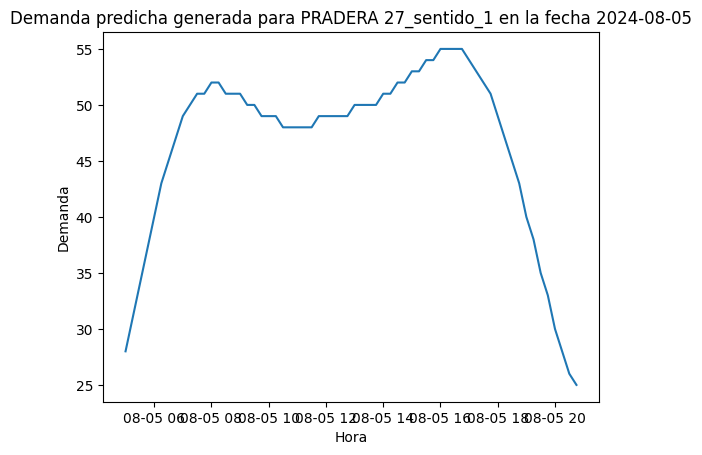

Demanda predicha generada para PRADERA 27_sentido_1 en la fecha 2024-08-05


In [9]:
# 1. Definir rutas y sentidos de interés
rutas = ['PRADERA 27']  # Puedes agregar más r utas según sea necesario

# 2. Diccionario para almacenar modelos y métricas
modelos = {}
metricas = {}
train_data = {}
test_data = {}

# 3. Entrenar modelos para cada ruta y sentido
for ruta in rutas:
    for sentido in sentidos:
        model, train_prophet, test_prophet, metrics = entrenar_modelo_prophet(
            data=data,
            ruta=ruta,
            sentido=sentido,
            frecuencia=frecuencia,
            split_date=split_date
        )
        if model is not None:
            clave = f"{ruta}_sentido_{sentido}"
            modelos[clave] = model
            metricas[clave] = metrics
            train_data[clave] = train_prophet
            test_data[clave] = test_prophet
            print(f"Modelo entrenado para {clave} con RMSE: {metrics['RMSE']}, MAE: {metrics['MAE']}")
        else:
            print(f"No se entrenó modelo para {ruta} en sentido {sentido} debido a falta de datos.")

# 4. Generar pronósticos futuros y preparar demandas para la heurística
demanda_predicha = {}

for clave, model in modelos.items():
    # Generar pronóstico futuro
    forecast_future = generar_pronostico_futuro(
        model=model,
        fecha_prediccion=fecha_prediccion,
        frecuencia=frecuencia
    )

    # Obtener demanda predicha
    demanda = obtener_demanda_predicha(forecast_future)

    # Almacenar en el diccionario
    demanda_predicha[clave] = demanda

    print(f"Demanda predicha generada para {clave} en la fecha {fecha_prediccion}")
    demanda_predicha

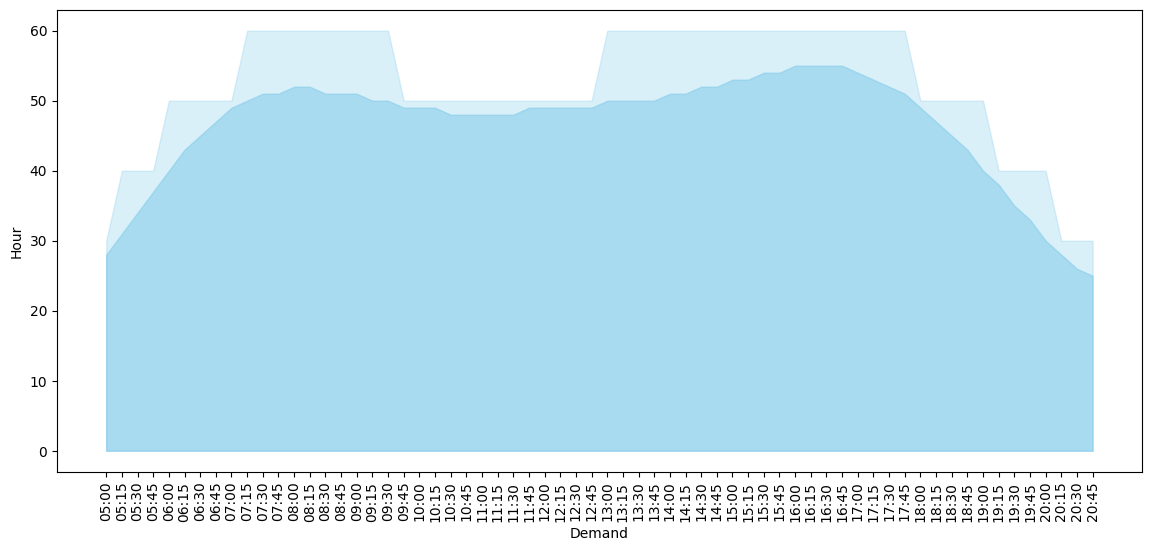

In [10]:
continous_demand = []
discrete_demand = []
x_plot = []
for date, demand in zip(list(forecast_future["ds"]), list(demanda_predicha["PRADERA 27_sentido_1"])):
    
    x_plot.append(date.strftime("%H:%M"))
    continous_demand.append(demand)
    discrete_demand.append(10*(int(demand/10)+1))

# Create the plot
plt.figure(figsize=(14, 6))

plt.fill_between(x_plot, continous_demand, color="skyblue", alpha=0.6, label="Continous")


plt.fill_between(x_plot, discrete_demand, color="skyblue", alpha=0.3, label="Discrete")

# Add labels and legend
plt.xlabel("Demand")
plt.ylabel("Hour")
plt.xticks(rotation=90)
custom_save_fig("../outputs/images/discrete_vs_continue_demand/pradera_27.png")
# Show the plot
plt.show()

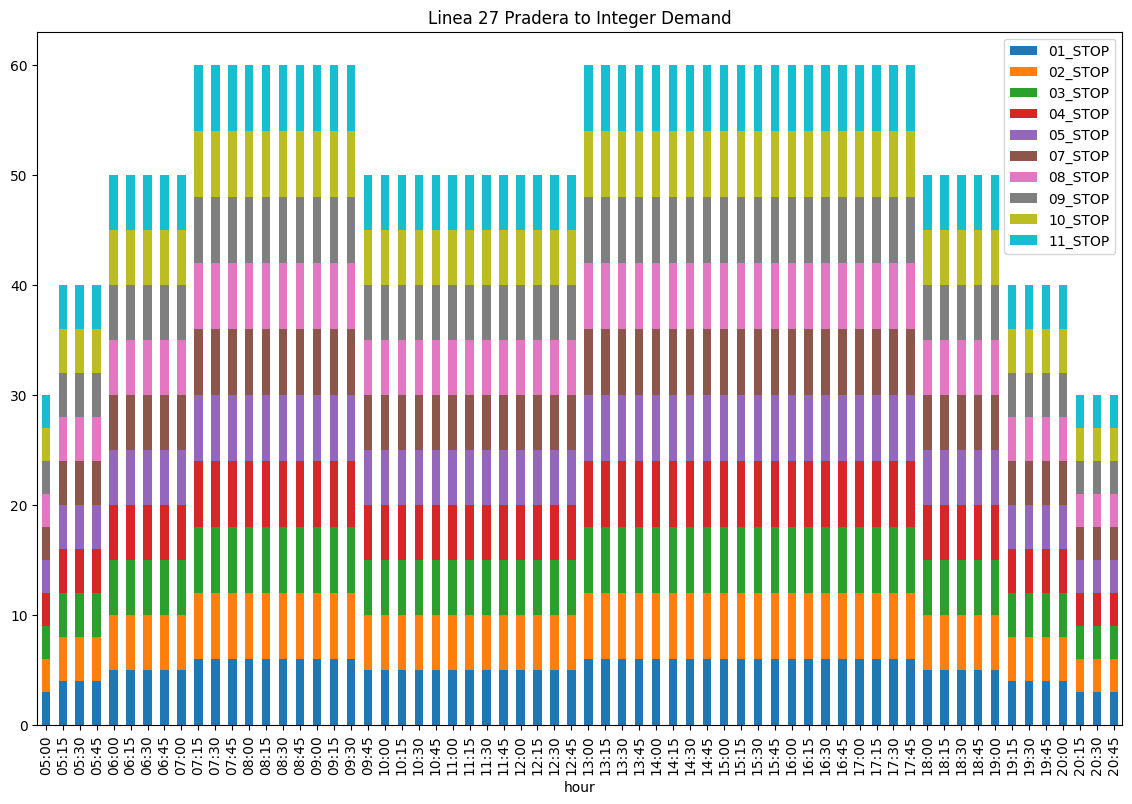

In [11]:

list_df = []
for date, demand in zip(list(forecast_future["ds"]), list(demanda_predicha["PRADERA 27_sentido_1"])):
    sub_dict = {
        "hour": date.strftime("%H:%M")
    }
    for node in (0,1,2,3,4,5,6,7,8,9,10,11,12):
        if node not in (0,6,12):
            sub_dict[f"{node:02}_STOP"] = int(int(demand/10)+1)
    list_df.append(sub_dict)
    
df_line = pd.DataFrame(list_df)
df_line.plot(
    x='hour',
    kind='bar',
    stacked=True,
    title='Linea 27 Pradera to Integer Demand',
    figsize=(14,9)
)
custom_save_fig("../outputs/images/discrete_demand_stop_split/pradera_27.png")
plt.show()

In [12]:
optimization_info = {}
for date, demand in zip(range(len(forecast_future["ds"])), list(demanda_predicha["PRADERA 27_sentido_1"])):
    for node in (0,1,2,3,4,5,6,7,8,9,10,11,12):
        if node not in (0,6,12):
            optimization_info[node, date] = int(int(demand/10)+1)
        else:
            optimization_info[node, date] = 0
custom_save_dict(optimization_info, "../outputs/model_input/pradera_27.csv")

### 4.2 Linea 3: PANZENU

/var/folders/lb/zdzvs7ds7zj7frbnmc7rh0_r0000gp/T/ipykernel_23419/3343168515.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_resampled = data_filtrada.resample(frecuencia).size().reset_index(name='demanda')
22:10:54 - cmdstanpy - INFO - Chain [1] start processing
22:10:57 - cmdstanpy - INFO - Chain [1] done processing


Modelo entrenado para ruta PANZENU en sentido 1
RMSE: 12.953711017425157
MAE: 10.4085119960367
Modelo entrenado para PANZENU_sentido_1 con RMSE: 12.953711017425157, MAE: 10.4085119960367


/Users/juan.agudelo/miniconda3/envs/ntf-demand/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(
/var/folders/lb/zdzvs7ds7zj7frbnmc7rh0_r0000gp/T/ipykernel_23419/3989350936.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future['ds'] = pd.date_range(start=f"{fecha_prediccion} 05:00:00", periods=periodos, freq=frecuencia)


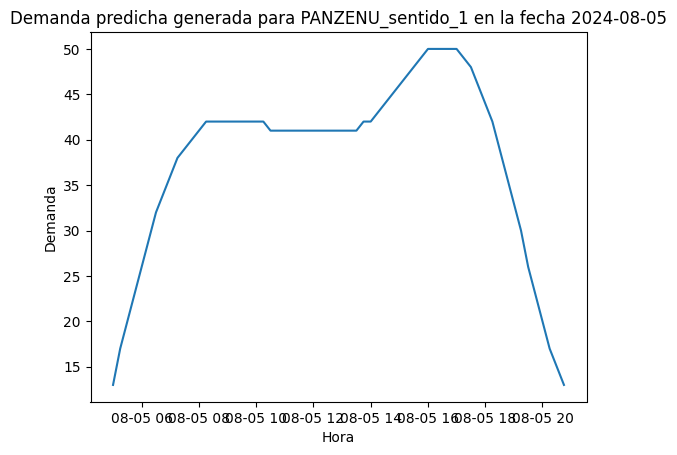

Demanda predicha generada para PANZENU_sentido_1 en la fecha 2024-08-05


In [13]:
# 1. Definir rutas y sentidos de interés
rutas = ['PANZENU']  # Puedes agregar más r utas según sea necesario

# 2. Diccionario para almacenar modelos y métricas
modelos = {}
metricas = {}
train_data = {}
test_data = {}

# 3. Entrenar modelos para cada ruta y sentido
for ruta in rutas:
    for sentido in sentidos:
        model, train_prophet, test_prophet, metrics = entrenar_modelo_prophet(
            data=data,
            ruta=ruta,
            sentido=sentido,
            frecuencia=frecuencia,
            split_date=split_date
        )
        if model is not None:
            clave = f"{ruta}_sentido_{sentido}"
            modelos[clave] = model
            metricas[clave] = metrics
            train_data[clave] = train_prophet
            test_data[clave] = test_prophet
            print(f"Modelo entrenado para {clave} con RMSE: {metrics['RMSE']}, MAE: {metrics['MAE']}")
        else:
            print(f"No se entrenó modelo para {ruta} en sentido {sentido} debido a falta de datos.")

# 4. Generar pronósticos futuros y preparar demandas para la heurística
demanda_predicha = {}

for clave, model in modelos.items():
    # Generar pronóstico futuro
    forecast_future = generar_pronostico_futuro(
        model=model,
        fecha_prediccion=fecha_prediccion,
        frecuencia=frecuencia
    )

    # Obtener demanda predicha
    demanda = obtener_demanda_predicha(forecast_future)

    # Almacenar en el diccionario
    demanda_predicha[clave] = demanda

    print(f"Demanda predicha generada para {clave} en la fecha {fecha_prediccion}")
    demanda_predicha

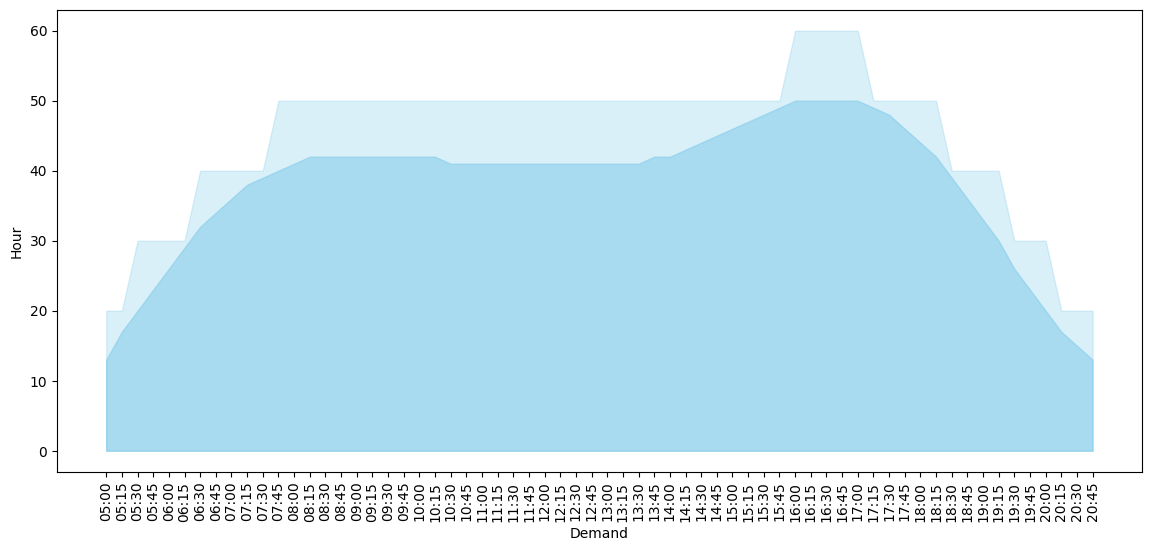

In [14]:
continous_demand = []
discrete_demand = []
x_plot = []
for date, demand in zip(list(forecast_future["ds"]), list(demanda_predicha["PANZENU_sentido_1"])):
    
    x_plot.append(date.strftime("%H:%M"))
    continous_demand.append(demand)
    discrete_demand.append(10*(int(demand/10)+1))

plt.figure(figsize=(14, 6))

plt.fill_between(x_plot, continous_demand, color="skyblue", alpha=0.6, label="Continous")

plt.fill_between(x_plot, discrete_demand, color="skyblue", alpha=0.3, label="Discrete")

# Add labels and legend
plt.xlabel("Demand")
plt.ylabel("Hour")
plt.xticks(rotation=90)
custom_save_fig("../outputs/images/discrete_vs_continue_demand/panzenu.png")
# Show the plot
plt.show()

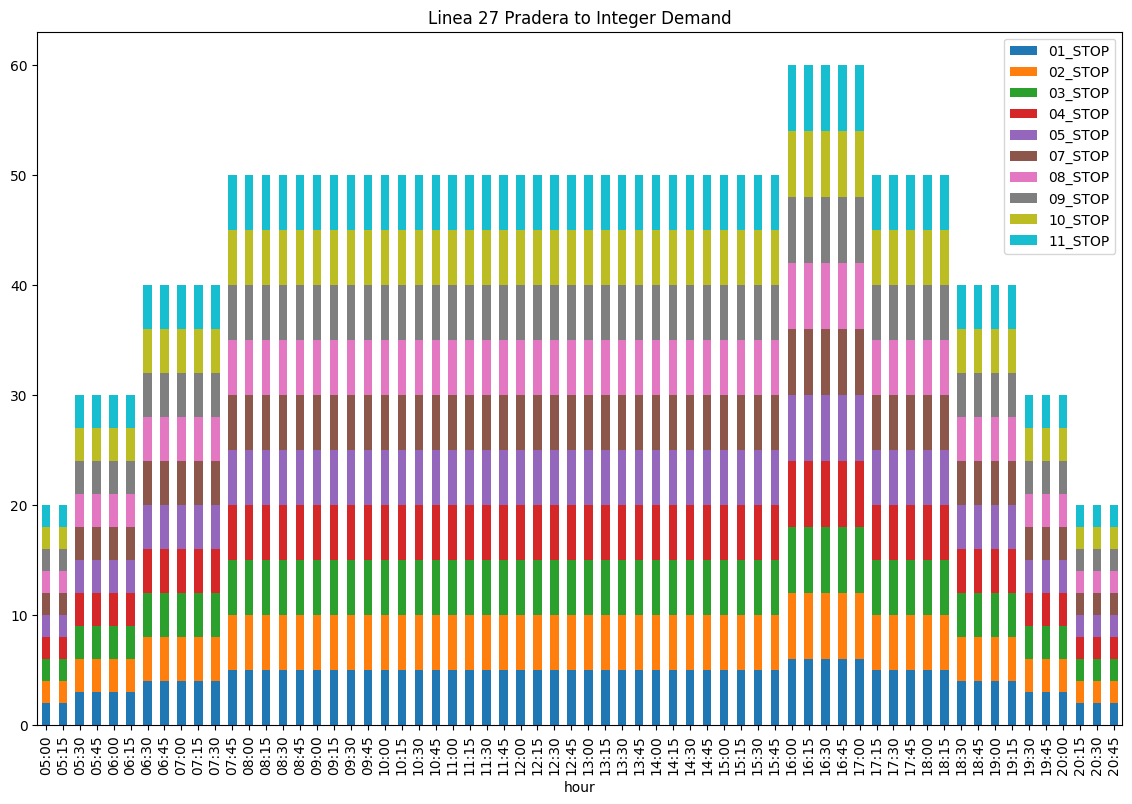

In [15]:

list_df = []
for date, demand in zip(list(forecast_future["ds"]), list(demanda_predicha["PANZENU_sentido_1"])):
    sub_dict = {
        "hour": date.strftime("%H:%M")
    }
    for node in (0,1,2,3,4,5,6,7,8,9,10,11,12):
        if node not in (0,6,12):
            sub_dict[f"{node:02}_STOP"] = int(int(demand/10)+1)
    list_df.append(sub_dict)
    
df_line = pd.DataFrame(list_df)
df_line.plot(
    x='hour',
    kind='bar',
    stacked=True,
    title='Linea 27 Pradera to Integer Demand',
    figsize=(14,9)
)
custom_save_fig("../outputs/images/discrete_demand_stop_split/panzenu.png")
plt.show()

In [16]:
optimization_info = {}
for date, demand in zip(range(len(forecast_future["ds"])), list(demanda_predicha["PANZENU_sentido_1"])):
    for node in (0,1,2,3,4,5,6,7,8,9,10,11,12):
        if node not in (0,6,12):
            optimization_info[node, date] = int(int(demand/10)+1)
        else:
            optimization_info[node, date] = 0
custom_save_dict(optimization_info, "../outputs/model_input/panzenu.csv")